<div style='direction:rtl;text-align:right;'>
    
# نمذجة البيانات والتحقق من النماذج - Model Validation

<div style='direction:rtl;text-align:right;'>
تحدثنا في الدرس السابق عن كيفية بناء النماذج التوقعية والتصنيفية. نستكمل في هذا الدرس الحديث عن أساليب تقييم هذه النماذج بشكل محايد لتصلح هذه النماذج للعمل مع بيانات خارجية.

<div style='direction:rtl;text-align:right;'>
لماذا نتحقق من النموذج إن كان قادراً على التوقع بنسبة دقة عالية جداً؟ هناك سبب بسيط جداً: وهو أننا دربنا النموذج على بيانات محلية وليس على كل البيانات الممكنة. فلكي يكون النموذج قابلاً للاستخدام، لابد أن يتمتع النموذج بالقدرة على التعميم والتنبؤ بالبيانات التي لم يتدرب عليها. (اضافة تشبيه).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<div style='direction:rtl;text-align:right;'>
للعمل مع البيانات في هذا الدرس، سنستخدم بيانات جاهزة من مكتبة تحليل البيانات للعمل معها. علماً بأن الخطوات ستكون مطابقة للعمل مع أي بيانات أخرى نظيفة.

In [2]:
from sklearn import datasets
data = datasets.fetch_california_housing()

<div style='direction:rtl;text-align:right;'>
سنلقي أولا نظرة على وصف البيانات كما يلي:

In [3]:
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

<div style='direction:rtl;text-align:right;'>
كما موضح في النص أعلاه هذه بيانات أسعار المنازل في كاليفورنيا ولكن على مستوى المقاطعات. تحتوي البيانات على 20,640 صف و 9 متغيرات. المتغير الهدف الذي نسعى لتوقعه هو متوسط سعر المنزل بينما نجد المتغيرات الأخرى كالتالي: متوسط الدخل، متوسط عمر المنزل، متوسط عدد الغرف، متوسط عدد غرف النوم، عدد السكان، متوسط الساكنين في المنزل.

<div style='direction:rtl;text-align:right;'>
السؤال الذي نود الإجابة عنه باستخدام نماذج التوقع هو: هل نستطيع باستخدام هذه المتغيرات توقع سعر المنزل؟ وماهو المتغير الأكثر تأثيراً وماهو المتغير الأقل تأثيراً ؟ 

In [4]:
X = data.data
y = data.target

In [5]:
dataset = pd.DataFrame(X, columns=data.feature_names)

In [6]:
dataset['AvePrice'] = y

In [7]:
dataset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,AvePrice
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   AvePrice    20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


<div style='direction:rtl;text-align:right;'>
كالعادة، قبل أن نقوم بأي عملية سنقوم أولاً بالاستكشاف الأولي للبيانات والتأكد من سلامة المتغيرات من أي شذوذ.

In [11]:
np.round( dataset.describe() , 2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,AvePrice
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57,2.07
std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00,1.15
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80,1.20
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49,1.80
75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01,2.65
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,5.00


<div style='direction:rtl;text-align:right;'>
في الجدول أعلاه نستطيع استنتاج الملاحظات التالية: <br>
    - يبدو أن قيم HouseAge موزعة بين القيمة الدنيا والقيمة القصوى، بينما في الأعمدة الأخرى مثل MedInc أو AveRooms أو AveBedrms نجد أن القيمة القصوى بعيدة جداً عن المتوسط الحسابي. وهذا يدل على وجود قيم كبيرة جداً في بعض الصفوف. <br>
    - في أول صف count نجد أن جميع الأعمدة لها نفس عدد الصفوف بما يعني أن جميع الصفوف مليئة بالبيانات ولا يوجد لدينا حقول فارغة.

<div style='direction:rtl;text-align:right;'>
بعد إلقاء نظرة جوية على جميع القيم، نريد الآن استخدام الرسم البياني لرؤية أي أنماط جديرة بالانتباه. ماذا نعني بأنماط جديرة بالانتباه؟ أي نريد رؤية أي شذوذ عن توزيع الأرقام بين القيم الدنيا والقيم القصوى، أو أي قيم مكررة بشكل يثير الانتباه.

<div style='direction:rtl;text-align:right;'>
الأمر التالي يقوم برسم جميع القيم كنقطة: في المحور السيني نجد الصفوف، فقيمة الصف الأول نجدها في أقصى اليسار بينما الصف الأخير في أقصى اليمين. في المحور الصادي نجد القيمة الفعلية للصف. 

<AxesSubplot:>

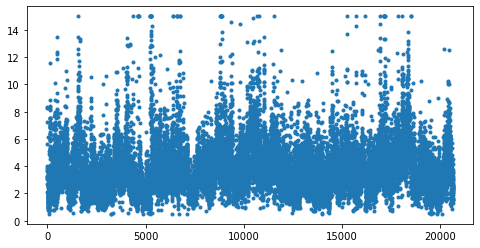

In [12]:
dataset['MedInc'].plot(style='.', figsize=(8,4))

<div style='direction:rtl;text-align:right;'>
بدلاً من رسم الأعمدة واحداً وراء الآخر، سنقوم باستخدام أمر for-loops لكي نمر على جميع الأعمدة ونرسمها في نفس الشكل باستخدام خاصية subplots.

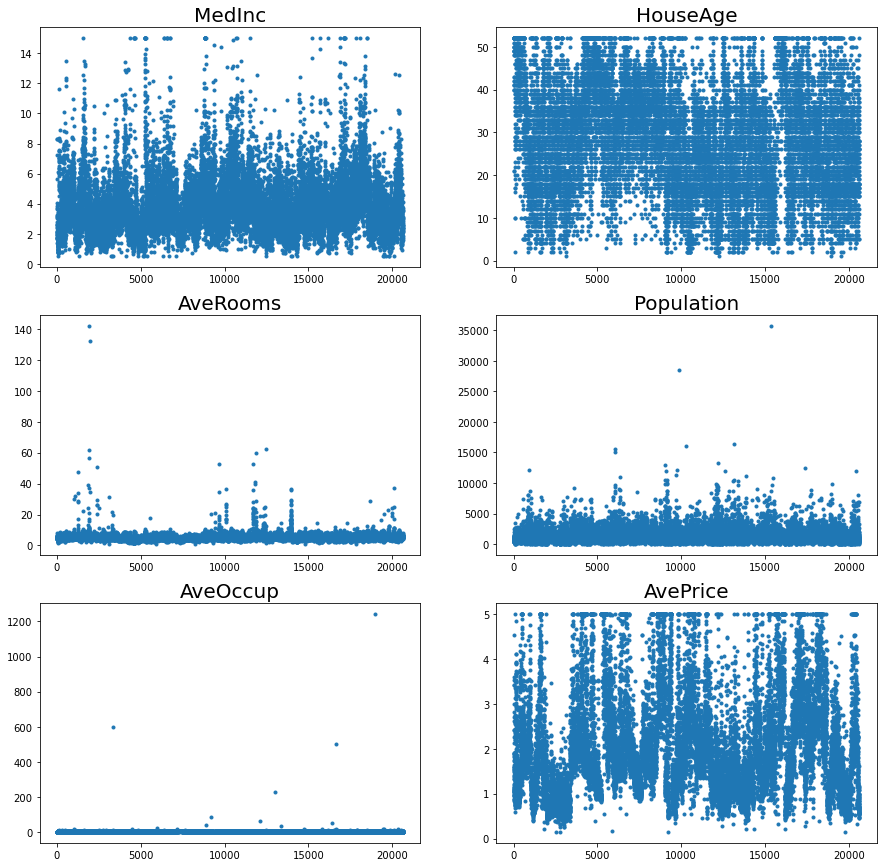

In [13]:
cols = ['MedInc', 'HouseAge', 'AveRooms','Population', 'AveOccup', 'AvePrice']
plt.figure(figsize=(15,15))
for ix, column in enumerate(cols):
    plt.subplot(3, 2, ix+1)
    dataset[column].plot(style='.')
    plt.title(column, fontsize=20)

<div style='direction:rtl;text-align:right;'>
ماذا نرى في الرسومات البيانية أعلاه؟ أولا: بعض المتغيرات (أو الأعمدة) لديها قيم متطرفة وكبيرة جداً مثل AveOccup، بينما متغيرات أخرى مثل MedInc و HouseAge و AvePrice متوزعة بشكل طبيعي تقريباً بين القيم الدنيا والصغرى.  ثانيا: بعض المتغيرات فيها قيم متكررة بشكل يثير الانتباه مثل HouseAge (ويمكن رؤية ذلك عبر خط من النقاط المتصلة عند القيمة القصوى) أو AvePrice. قد لا تشكل هذه الملاحظة أهمية في هذا السياق ولكن عليك دوماً أن تتفقد صحة هذه القيم والتحقق من أنها ليست نتيجة قرارات بشرية (مثل استبدال جميع القيم العالية بهذه القيمة).

<div style='direction:rtl;text-align:right;'>
كما أسلفنا، بعض المتغيرات توجد بها قيم متطرفة جداً. ولكي نقوم بالتحليل الأمثل فنحن أمام خيارين: إما التعامل مع تلك الصفوف أو التخلص منها.

<div style='direction:rtl;text-align:right;'>

## الانحدار الخطي

<div style='direction:rtl;text-align:right;'>
سنقوم الآن بإنشاء نموذج تنبؤي عبارة عن انحدار خطي متعدد لتقييم العلاقة بين المتغيرات وبين متوسط أسعار المنازل في ثلاثة أسطر فقط.

In [14]:
from sklearn import linear_model
regression_model = linear_model.LinearRegression()
regression_model.fit(X,y)

LinearRegression()

<div style='direction:rtl;text-align:right;'>
نستطيع الآن بعد أن تم بناء النموذج الرياضي، استخدام نفس النموذج في توقع أسعار المنازل باستخدام الأمر predict وطباعة أول خمس توقعات:

In [15]:
predictions = regression_model.predict(X)

<div style='direction:rtl;text-align:right;'>
بعد أن حسبنا توقعات النموذج الذي أنشأناه، نريد الآن مقارنة توقعات النموذج مع الأسعار الحقيقية للمنازل. عملية مقارنة التوقعات بالأسعار الحقيقية تهدف إلى تقييم أداء النموذج: هل يستطيع النموذج فهم وتمثيل البيانات بشكل قريب من الواقع؟

<div style='direction:rtl;text-align:right;'>
لاختبار ذلك، سنقوم برسم السعر الحقيقي في محور السينات، ورسم السعر المتوقع في محور الصادات، لنرى مدى التناسق بين القيم الحقيقية وبين التوقعات. في حالة كانت توقعات النموذج قريبة من الواقع، فسترى أن النقاط تتجمع حول الخط الأسود الذي يبين الأرقام الحقيقية. أما إن كانت تنحرف حول الخط باستمرار، فهذا يعني أن النموذج يعطي توقعات بعيدة نسبياً عن القيم الحقيقية.

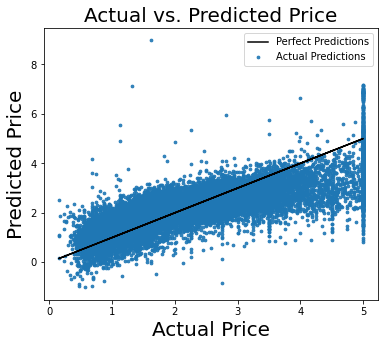

In [19]:
plt.figure(figsize=(6,5))
plt.scatter(y, predictions, s=30, marker='.', alpha=.9)
plt.plot(y, y, 'black')
plt.xlabel('Actual Price', fontsize=20)
plt.ylabel('Predicted Price', fontsize=20)
plt.title('Actual vs. Predicted Price', fontsize=20)
plt.legend({'Actual Predictions', 'Perfect Predictions'})
plt.show()

<div style='direction:rtl;text-align:right;'>
نظرة أولى على الرسم أعلاه ترينا أن هناك خطأ ما سبق أن رأيناه سابقاً وهو أن عدد لا بأس به من البيانات في عمود AvePrice لديها قيمة موحدة وهي 5، وهذا ما يفسر الخط العمودي فوق قيمة العدد 5. لكن فيما عدا ذلك، نرى أن النموذج يعطي توقعات تقريباً حول القيم الحقيقية ولكن نجد أن النموذج يعطي المنازل الغالية (ابتداء من 3 مليون) قيم أقل من قيمتها الحقيقية وباستمرار. 

<div style='direction:rtl;text-align:right;'>
كل هذه الملاحظات أعلاه مهمة لتفسير أداء النموذج. ولكن لكي نقوم بذلك بطريقة رياضية ودقيقية، سنقوم باستخدام أساليب تقييم النماذج Model Evaluation المتبعة.

<div style='direction:rtl;text-align:right;'>
ولكن كيف سنقوم بتقييم النموذج ؟ بكل بساطة، تقييم النموذج قائم على فكرة قياس الخطأ (الفرق بين القيم الحقيقية والتوقعات) وتحويل هذا إلى رقم نستطيع أن نقيم به أداء النموذج. سنتطرق في هذا الدرس إلى طريقتين لتقييم أداء النماذج: معدل الخطأ التربيعي (Mean Squared Error) ومربع الترابط (R^2 Score). <br>    
    أحد أهم طرق تقييم نماذج التوقع هي بحساب معدل الخطأ التربيعي. في معدل الخطأ التربيعي، نحسب الفرق بين القيم الأصلية والقيم المتوقعة ومن ثم نحسب المتوسط الحسابي لها. نقوم طبعاً بعملية رفع هذا الفرق إلى 2 قبل حساب المتوسط وذلك لأننا نريد أن نتخلص من القيم السالبة في الفرق. سنقوم بحساب هذا المعدل ونرى النتيجة، بالطبع قيمة 0 تعني أن النموذج قادر على إعطاء نتيجة مطابقة للقيم الحقيقية. او بعبارة أخرى يقوم النموذج بتوقع سعر المنزل بنسبة 100% بدون أي أخطاء. وكلما زادت القيمة عن 0 كلما ساء أداء النموذج.

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
# (actual - predicted) to power 2 (نستخدم الأس التربيعي) 
np.power(  y-predictions  ,2).mean()

0.5243209861846071

<div style='direction:rtl;text-align:right;'>
أو لندع مكتبة سايكت ليرن تقوم بالمهمة باستخدام الأمر mean_squared_error ومن ثم نضع القيم الحقيقية، متبوعة بالقيم المتوقعة.

In [23]:
print("Mean squared error: %.2f" % mean_squared_error(y, predictions))

Mean squared error: 0.52


<div style='direction:rtl;text-align:right;'>
بما أن الأسعار بالملايين، فهذا يعني أننا في المتوسط على بعد حوالي نصف مليون من السعر الحقيقي. قد لا تبدو هذه نتيجة مثيرة لكنها كذلك ليست سيئة أبداً. المشكلة في معدل الخطأ التربيعي هو أننا لا نعرف الحد الأعلى الذي نعرف من خلاله أن النموذج سيء للغاية. فلا نعرف من معدل الخطأ التربيعي إلا المسافة بين الحقيقة والتوقعات. لتعديل هذا الأمر، ستقوم بحساب قيمة تدعى ب R^2 أو آر سكويرد. هذه القيمة تأخذ القيم المتوقعة والقيم الحقيقية، وتوجد الترابط Correlation بينهما. وبعد ذلك نقوم بتربيع هذه القيمة لنحصل على ما يسمى ب Explained Variance أو معدل التباين الذي نستطيع توقعه من خلال النموذج. بالطبع، قيمة 1 يعني أن النموذج قادر على توقع القيم الحقيقية بنسبة  100% لكن بالمقابل، قيمة 0 يعني أن النموذج غير قادر على توقع النتائج الحقيقية أبداً. لحساب هذا سنقوم بعمل التالي:

In [24]:
np.power(np.corrcoef(y, predictions)[0,1], 2)

0.6062326851998052

<div style='direction:rtl;text-align:right;'>
أو باستخدام الأمر r2_score:

In [25]:
print('Variance score: %.2f' % r2_score(y, predictions))

Variance score: 0.61


<div style='direction:rtl;text-align:right;'>
وهذا يعني أن النموذج قادر على شرح 60% من التباين في هذه البيانات. بمعنى آخر، 60% من مجمل الاختلافات في أسعار المنازل الحقيقية يمكن التحسب لها من خلال هذا النموذج.

<div style='direction:rtl;text-align:right;'>
سنتطرق لاحقاً إلى كيفية استخدام هذه الأرقام في مقارنة النماذج المختلفة. ولكن جميع المعايير أعلاه (معدل الخطأ التربيعي ومربع التوافق) تستخدم فقط إن كنا نستخدم نماذج التوقع. كيف نقيم أداء النماذج القائمة على التصنيف؟

<div style='direction:rtl;text-align:right;'>
لنقم أولاً بتحويل مشكلة توقع أسعار المنازل إلى توقع غلاء المنازل. فبدلاً من العمل مع الأسعار الحقيقية، سنحول الأسعار إلى تصنيفات تتراوح من 1 (سعر متدني) إلى 5 (سعر مرتفع). وسنقوم بعدها ببناء نموذج لتوقع تصنيف السعر بدلاً من توقع السعر نفسه. ولنفترض جدلاً أننا وجدنا البيانات بهذه الحال.

In [28]:
y_category = pd.cut(y, 5, labels=[1,2,3,4,5])
y_category

[5, 4, 4, 4, 4, ..., 1, 1, 1, 1, 1]
Length: 20640
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [29]:
y_category = y_category.astype(np.int) # convert to array
y_category

C:\Users\KRM020~1\AppData\Local\Temp/ipykernel_12764/788695497.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_category = y_category.astype(np.int) # convert to array


array([5, 4, 4, ..., 1, 1, 1])

<div style='direction:rtl;text-align:right;'>
الآن سنستدعي أحد النماذج الخطية الذي يستخدم للتصنيف ألا وهو النموذج اللوجستي (Logstic Regression). في النموذج اللوجستي، نحاول تمثيل البيانات بطريقة مشابهة لما رأيناه في الانحدار الخطي أعلاه ولكن بدلاً من توقع قيمة أو رقم ما (مثل سعر المنزل أو عدد الأولاد أو العُمر أو ما إلى ذلك)، سنقوم بتوقع مدى انتماء عينة من البيانات إلى فئة أو تصنيف. بعد ذلك سنقوم باستخدام الأمر predict لتوقع تصنيف سعر المنزل.

In [30]:
logistic_model = linear_model.LogisticRegression()
logistic_model.fit(X,y_category)

C:\Users\KRM0201517\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [31]:
predictions_logistic = logistic_model.predict(X)
predictions_logistic

array([5, 3, 5, ..., 1, 1, 1])

<div style='direction:rtl;text-align:right;'>
السؤال المطروح الآن بعد أن حصلنا على توقعات النموذج: كيف نقيم أداء هذا النموذج اللوجستي؟ أسلوب استخدام الفرق بين التصنيفات المتوقعة من النموذج والتصنيفات الحقيقية لن يعمل في هذه الحالة لأن الأرقام 1, 2 ,3 ,4 ,5 التي استخدمناها اعتباطية إن صح التعبير: فالرقم 2 مثلاً ليس هو ضعف ال1 أو نصف الـ 4 في هذه الحالة، بل هو اسم استخدمناه لوصف مجال معين من أسعار المنازل وقد نستخدم بدلاً عنه أي رقم أو نص آخر مثل 4 أو 'رخيص إلى حد ما' وما إلى ذلك.

<div style='direction:rtl;text-align:right;'>
الجواب على هذا السؤال هو باستخدام مايعرف بال Confusion Matrix أو مصفوفة الالتباس. في هذه المصفوفة، بما أن لدينا خمس أصناف سيكون لدينا 5 صفوف و 5 أعمدة. محور السينات سيمثل الأصناف المتوقعة من النموذج، بينما في محور الصادات سيكون لدينا الأصناف الحقيقية. مثلاً في خانة الصف الأول والعمود الأول سنجد عدد الصفوف التي توقعها النموذج لتكون من صنف 1 بينما قيمتها الحقيقية هو كذلك 1. بينما في خانة الصف الثاني والعمود الرابع سنجد القيم التي توقعها النموذج لتكون من الصنف 4 ولكنها في الحقيقية من الصنف 2 وهكذا. بما أن المصفوفة مربعة الشكل، كل الخانات على القطر (مثلا: الصف الأول العمود الأول، الصف الثاني العمود الثاني، الصف الثالث العمود الثالث .. الخ) تمثل التوقعات الصحيحة للنموذج، بينما جميع الخانات الأخرى تمثل التوقعات الخاطئة. في النموذج المثالي، ستكون قيم جميع التوقعات الخاطئة في جميع الخانات غير القطرية هي صفر، بينما في الخانات القطرية ستكون عدد الصفوف التي تملك تلك القيمة من الأساس.

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
cmatrix = confusion_matrix(y_category, predictions_logistic)
cmatrix_ideal = confusion_matrix(y_category, y_category)

In [34]:
cmatrix

array([[ 740, 3705,   37,    0,    7],
       [ 647, 6872,  333,    0,   18],
       [ 119, 3997,  425,    0,   27],
       [  27, 1544,  365,    0,   55],
       [  20, 1080,  379,    0,  243]], dtype=int64)

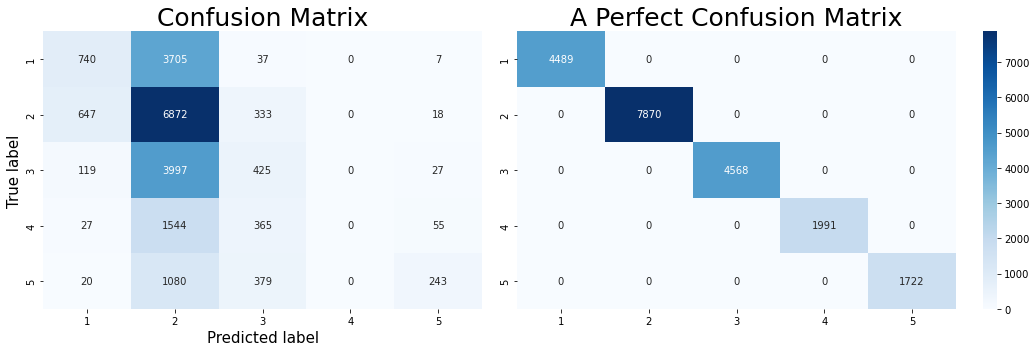

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.heatmap(cmatrix,cmap="Blues", annot=True, fmt='g',  xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title('Confusion Matrix', fontsize=25)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.tight_layout()

plt.subplot(1,2,2)
sns.heatmap(cmatrix_ideal, cmap="Blues", annot=True, fmt='g',  xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title('A Perfect Confusion Matrix', fontsize=25)
#plt.ylabel('True label', fontsize=15)
#plt.xlabel('True label', fontsize=15)
plt.tight_layout()

<div style='direction:rtl;text-align:right;'>
ماذا نلاحظ في مصفوفة الالتباس أعلاه؟ نلاحظ أن هناك التباس كبير بين الصنفين 1 و 2 وكذلك بين 2 و 3، بينما نجد قدر أقل من الالتباس بين صنفي 1 و 2 وبين بقية الأصناف (لاحظ القيم في خانات الصف 1 والعمود 1). ماذا أيضاً؟ نلاحظ أن النموذج لا يستطيع أبداً تمثيل الصنف 4 حيث أن الصفوف التي تنتمي لهذا الصنف يتوقعها النموذج ك 2 أو 3 أو 5 في الغالب. نلاحظ أن مصفوفة الالتباس تعطينا صورة عامة عن نقاط ضعف النموذج.

<div style='direction:rtl;text-align:right;'>
ولكن يظل السؤال قائماً، كيف نستطيع تقييم النموذج برقم واحد وبسيط يسهل علينا عملية المقارنة بين نماذج مختلفة؟ لدينا في الواقع عدد من وسائل التصنيف لعل أسهلها هو قياس دقة النموذج (Accuracy) وذلك بحساب مجموع التوقعات الصحيحة وقسمته على جميع التوقعات. 

In [36]:
np.mean(y_category == predictions_logistic)

0.4011627906976744

<div style='direction:rtl;text-align:right;'>
أو باستخدام أمر accuracy_score:

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
acc_score = accuracy_score(y_category, predictions_logistic)

In [39]:
print('Model Accuracy = {}%'.format(np.round(acc_score*100,2)))

Model Accuracy = 40.12%


<div style='direction:rtl;text-align:right;'>
أي أن النموذج قادر على توقع نصف البيانات فقط بشكل صحيح. هذا ليس بالضرورة مؤشراً على سوء النموذج خصوصاً في حالة كثرة التصنيفات (كما هو الحال في هذا المثال). ولكن هو رقم نستخدمه لمقارنة النماذج المختلفة لاختيار الأفضل بينها.

<div style='direction:rtl;text-align:right;'>

## Cross Validation

<div style='direction:rtl;text-align:right;'>
لكن هناك مشكلة كبيرة. هذه البيانات جمعت قبل سنين عديدة، ولو جمعنا بيانات جديدة فلن نحصل على هذه القيم بكل تأكيد، ربما أكثر وربما أقل. لكن كيف نعرف ؟ قدرة النموذج على التعميم على بيانات غير موجودة هي التي تحدد كفاءته وقوته، وليس فقط دقة التوقعات في البيانات التي دربنا النموذج عليها. فكيف نستطيع حل هذا الإشكال؟

<div style='direction:rtl;text-align:right;'>
لحل هذا الإشكال، ابتكر علماء الإحصاء طريقة بسيطة: وهي أن نقسم البيانات إلى قسمين أو ثلاثة (أو أي رقم) ومن ثم نقوم باستخدام بعض هذه الأقسام لبناء النموذج الرياضي، ونقوم باختباره على الأقسام الأخرى. هذا الحل سيعطينا، على المدى الطويل، تنبؤ أكثر دقة بمدى موثوقية التوقعات. في المثال التالي، سنقوم بتقسيم البيانات إلى قسمين فقط: training data و testing data. الأولى نستخدمها في بناء النموذج، والثانية نستخدمها في اختبار القدرة التنبؤية على بيانات جديدة. لعمل ذلك سنقوم بالتالي:

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
# 70% of data for training and 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  

<div style='direction:rtl;text-align:right;'>
قمنا للتو بتقسيم البيانات إلى قسمين: لنستخدم تقريباً ثلثي البيانات لتدريب النموذج ونستخدم الثلث الأخير لاختبار النموذج. في الخانة التالية سنطبع عدد الصفوف والأعمدة في كل قسم:

In [42]:
print('Training data: ', X_train.shape, y_train.shape)
print('Testing data: ', X_test.shape, y_test.shape)

Training data:  (14448, 8) (14448,)
Testing data:  (6192, 8) (6192,)


<div style='direction:rtl;text-align:right;'>
الآن سنقوم بتدريب النموذج على ثلثي البيانات المسماة ب X_train. وهذا يعني أن نستخدم الأمر fit على هذا المتغير. لاحقاً، سنقوم باستخدام predict ونضع قيم الثلث الأخير ومن ثم نقارنها بالقيم الحقيقية من الثلث الأخير لنقيم أداء النموذج.

In [43]:
regression_model = linear_model.LinearRegression()
regression_model.fit(X_train,y_train)
predictions = regression_model.predict(X_test)
print(mean_squared_error(y_test, predictions))

0.5305677824766759


<div style='direction:rtl;text-align:right;'>
كما نرى، فمعدل الخطأ التربيعي قريب جداً من المعدل الأصلي وهذا يعني أن النموذج فيه قدر كبير من الوثوقية (بالرغم من الأداء السيء). نستطيع تكرار الأمر على النموذج اللوجستي ونرى كيف يعمل مع بيانات جديدة تماما.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y_category, test_size=0.3, random_state=42)  
logistic_model = linear_model.LogisticRegression()
logistic_model.fit(X_train,y_train)
predictions_logistic = logistic_model.predict(X_test)
print(accuracy_score(y_test, predictions_logistic))

0.3825904392764858


C:\Users\KRM0201517\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<div style='direction:rtl;text-align:right;'>
مرة أخرى، نرى أن النسبة هنا (~52%) قريبة جداً من نسبة الدقة باستخدام جميع البيانات مما يعني أن النموذج أيضاً قادر على التعامل مع بيانات جديدة.